In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Application de la méthode de Galerkine aux données
"""

#DataFolder="C:/Users/Julie_000/Desktop/Stage/Stage_l3"
DataFolder="E:/Clément/Julie/Stage_L3"

In [2]:
from mat4py import loadmat #pour charger des .mat
import matplotlib
import matplotlib.pyplot as plt # pour tracer les figures
import os # pour modifier le dossier de travail
import numpy as np 
from pathlib import Path # Pour rendre les Path compatibles entre Mac et Windows
from matplotlib import rc #Les trois prochaines lignes pour que Ã§a ressemble Ã  latex
rc('font', size=16)
rc('text', usetex=True)
import scipy as sc
import matplotlib.cm as cm #colormaps
from matplotlib.colors import Normalize #Pour l'utilisation des couleurs dans quiver
from matplotlib.ticker import MaxNLocator #pour les courbes de niveau
from scipy.ndimage import gaussian_filter #Filtrage gaussien
import matplotlib.patches as mpatches #pour le nageur

from scipy.linalg import pinv as scpinv
from numpy.linalg import pinv as nppinv


from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve

import fonctions_projet_divergence as fpd#pour les données

colormap2=cm.PiYG#colormap

from mpl_toolkits.mplot3d import Axes3D#plot3D

In [3]:
def PIV(prof,manips): 
    """retourne les données des plans pour la bonne profondeur"""
    if prof==5:
        piv=manips['piv5']
    elif prof==10:
        piv=manips['piv10']
    elif prof==15:
        piv=manips['piv15']
    else:
        return("prof n'a pas une valeur acceptable")   
    return(piv)

def nb_plan(prof):
    "Détermine le nombre de plan pour une profondeur donnée"
    if prof==5:
        return(16)
    if prof==10:
        return(32)
    if prof==15:
        return(49)
    else:
        return("prof n'a pas une valeur acceptable")
    
def donnees(n,piv,size):
    "Charge les données pour la profondeur donnée"
    umo=np.zeros((n,size,size))
    vmo=np.zeros((n,size,size))
    ume=np.zeros((n,size,size))
    vme=np.zeros((n,size,size))
    uva=np.zeros((n,size,size))
    vva=np.zeros((n,size,size))
    cu=np.zeros((n,size,size))
    cv=np.zeros((n,size,size))
    x=np.zeros((n,size,size))
    y=np.zeros((n,size,size))
    z=np.zeros((n))

    for plan in range(n): 
            umo[plan]=np.array(piv[plan]['umoy'])
            vmo[plan]=np.array(piv[plan]['vmoy'])
            ume[plan]=np.array(piv[plan]['umed'])
            vme[plan]=np.array(piv[plan]['vmed'])
            uva[plan]=np.array(piv[plan]['uvar'])
            vva[plan]=np.array(piv[plan]['vvar'])
            cu[plan]=np.array(piv[plan]['cu'])
            cv[plan]=np.array(piv[plan]['cv'])
            x[plan]=np.array(piv[plan]['x'])
            y[plan]=np.array(piv[plan]['y'])
            z[plan]=np.array(piv[plan]['prof'])
    return(umo,vmo,ume,vme,uva,vva,cu,cv,x,y,z)

def conv(u,plan,variable_fixe):
    "Met les array sous la bonne forme"
    if np.ndim(u)==3:
        if variable_fixe=='x':
            return(np.transpose(u[:,:,plan]))
        elif variable_fixe=='y':
            return(np.transpose(u[:,plan,:]))
    elif np.ndim(u)==4:
        conv=np.zeros((np.shape(u)[0],size-1,P))
        if variable_fixe=='x':
            for i in range(np.shape(u)[0]):
                conv[i]=np.transpose(u[i,:,:,plan])
            return(conv)
        elif variable_fixe=='y':
            for i in range(np.shape(u)[0]):
                conv[i]=np.transpose(u[i,:,plan,:])
            return(conv)
        
def vitesse_nageur(prof):
    "donne la vitesse du nageur pour une profondeur. Elle est suivant ey"
    if prof==5:
        return(60)
    elif prof==10:
        return(59)
    elif prof==15:
        return(62)
    
    
def plot_champ_vitesse(u,v,x,y,title):
    "Fonction de tracé du champ de vitesse"
    #norme
    velocity=np.sqrt(u**2+v**2)
    velmax=np.mean(velocity)+3*np.std(velocity)#norme maximale représentée sur la colormap borne sup arbitraire
    colors = np.copy(velocity)
    colors[velocity>velmax]=velmax
    colormap=cm.magma#colormap je crois que cette commande ne fonctionne pas
    norm = Normalize()
    norm.autoscale(colors)

    #plot   
    fig,ax=plt.subplots(num=title)
    im=ax.quiver(x[::2,::2],y[::2,::2],u[::2,::2]/velocity[::2,::2],v[::2,::2]/velocity[::2,::2],colors[::2,::2])
    fig.colorbar(im, ax=ax)  #pour la barre de couleur
    
    fig.suptitle(title,fontsize=16)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()
    
    
def plot_divergence(div,dx,dy,title,vmin,vmax):
    "Tracé des divergences"
    #norme
    #dx=dx[20:80,30:90]
    #dy=dy[20:80,30:90]
    #div=div[20:80,30:90]
    norm=Normalize(vmin=vmin, vmax=vmax)
    levels = MaxNLocator(nbins=255).tick_values(vmin,vmax)
    
    fig, l0 = plt.subplots(num=title)
    im0 = l0.contourf(dx,dy,div,levels=levels, cmap=colormap2,norm=norm)
    fig.colorbar(im0,ax=l0)
    l0.set_xlabel('x')
    l0.set_ylabel('y')
    circle = mpatches.Circle((0,0), 6, color='snow')#patch
    l0.add_patch(circle)
   
    fig.tight_layout(pad = 3)
    fig.suptitle(title,fontsize=20)
    plt.show()
    
def divergence2D_astropy(u,v,x,y,sigma):
    "Applique le programme de divergence2D avec filtre gaussien sur la vitesse"
    unan=np.copy(u)
    vnan=np.copy(v)
    unan[u==0]=np.nan
    vnan[v==0]=np.nan
    #Filtrage
    # We smooth with a Gaussian kernel with x_stddev=1 (and y_stddev=1)
    # It is a 9x9 array
    kernel = Gaussian2DKernel(x_stddev=sigma,y_stddev=sigma)

    # astropy's convolution replaces the NaN pixels with a kernel-weighted
    # interpolation from their neighbors
    u_filtre = convolve(unan, kernel)
    v_filtre = convolve(vnan, kernel)

    
    #dérivation
    du_filtre,dv_filtre=fpd.deriv(u_filtre,x,1),fpd.deriv(v_filtre,y,0)
    dx=fpd.abcisse(x,1)
    dy=fpd.abcisse(y,0)
    #shape
    du_filtre,dv_filtre=fpd.good_shape(du_filtre),fpd.good_shape(dv_filtre)
    dx,dy=fpd.good_shape(dx),fpd.good_shape(dy)
    #somme
    div = fpd.somme(du_filtre,dv_filtre)
    #masque
    div_masque=fpd.masque(div,x,y,dx,dy)
    return(div_masque,dx,dy)

def methode_Galerkine_2(u,v,x,y,z,P,m,h):
    "Galerkine en ignorant les valeurs nulles"
    #divergence bidimensionelle
    div_2D=np.zeros((P,size-1,size-1))
    dx=np.zeros((P,size-1,size-1))
    dy=np.zeros((P,size-1,size-1))
    vz=np.zeros((P,size-1,size-1))
    dvz=np.zeros((P,size-1,size-1))

    for plan in range(P):
        div_2D[plan],dx[plan],dy[plan]=divergence2D_astropy(u[plan],v[plan],x[plan],y[plan],2)
    for i in range(size-1):
        for j in range(size-1):
            divij=div_2D[:,i,j]
            zcor=z[divij==divij] #False pour un NaN, True sinon
            divijcor=divij[divij==divij]
            pinv=nppinv(np.transpose(np.array([n*np.pi/h*np.cos(n*np.pi/h*zcor) for n in range(1,m+1)])))
            a=np.matmul(pinv,divijcor)
            sin=np.transpose(np.array([np.sin(n*np.pi*z/h) for n in range(1,m+1)]))
            dsin=np.transpose(np.array([n*np.pi/h*np.cos(n*np.pi*z/h) for n in range(1,m+1)]))

            a=np.reshape(a,(np.shape(a)[-1]))
            sin=np.reshape(sin,(np.shape(sin)[-2],np.shape(sin)[-1]))
            dsin=np.reshape(dsin,(np.shape(dsin)[-2],np.shape(dsin)[-1]))

            if len(zcor)>2*m:
                vz[:,i,j]=np.matmul(sin,a)
                dvz[:,i,j]=np.matmul(dsin,a)
            div_3D=div_2D+dvz
    return(vz,dvz,div_2D,div_3D)

In [4]:
prof=15 # Choisi sur quelle profondeur d'eau travailler (5, 10 ou 15 mm)

In [5]:
os.chdir(Path(DataFolder)) # se place dans le dossier où est rangée la manip
manips=loadmat('PIVnagseulall.mat') # Charge les données dans la variable manip

piv=PIV(prof,manips)#données pour la profondeur

P=nb_plan(prof)#nombre de plan dans la profondeur choisie
size=len(np.array(piv[0]['umoy']))

umo,vmo,ume,vme,uva,vva,cu,cv,x,y,z=donnees(P,piv,size)
#print(np.shape(u0),np.shape(v0),np.shape(x0),np.shape(y0),np.shape(z))

v_nageur=vitesse_nageur(prof)

# Comparaison de différentes façons de traiter les résultats de PIV
En haut à gauche : moyenne
En haut à droite : médiane
En bas à gauche : moyenne avec des 0 là où il y a moins de 10% d'info
En bas à droite : moyenne avec des 0 là où l'écart-type est plus grand que le vecteur

C:\Users\clement.gouiller\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
C:\Users\clement.gouiller\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater
C:\Users\clement.gouiller\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in greater
C:\Users\clement.gouiller\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in less
C:\Users\clement.gouiller\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in less
C:\Users\clement.gouiller\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


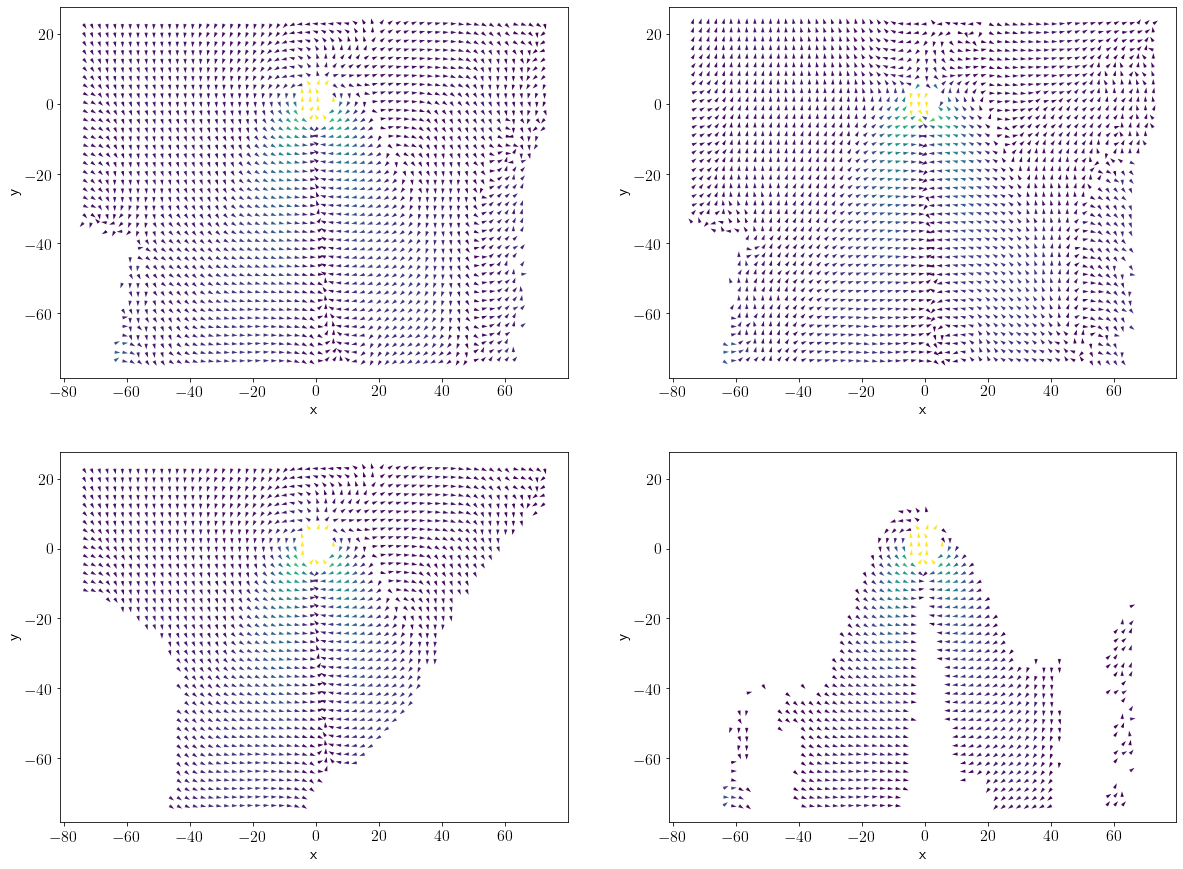

In [6]:
plt.rcParams['figure.figsize'] = [20, 15] # taille par défaut des figures qu'on trace
fig, axs = plt.subplots(2,2)
axs = axs.ravel()
plan=15
#plot_champ_vitesse(u0[plan],v0[plan],x0[plan],y0[plan],"Champ de vitesse du plan 2 de la profondeur 15")


u=np.copy(umo[plan])
v=np.copy(vmo[plan])
cup=cu[plan]
cvp=cv[plan]
u[cup<=50]=0
v[cvp<=50]=0
velocity=np.sqrt(u**2+v**2)
velmax=np.mean(velocity)+3*np.std(velocity)#norme maximale représentée sur la colormap borne sup arbitraire
colors = np.copy(velocity)
colors[velocity>velmax]=velmax
norm = Normalize()
norm.autoscale(colors)
axs[2].quiver(x[plan,0:80:2,::2],y[plan,0:80:2,::2],u[0:80:2,::2]/velocity[0:80:2,::2],v[0:80:2,::2]/velocity[0:80:2,::2],colors[0:80:2,::2])
axs[2].set_xlabel("x")
axs[2].set_ylabel("y")


u=np.copy(umo[plan])
v=np.copy(vmo[plan])
velocity=np.sqrt(u**2+v**2)
#velmax=np.mean(velocity)+3*np.std(velocity)#norme maximale représentée sur la colormap borne sup arbitraire
colors = np.copy(velocity)
colors[velocity>velmax]=velmax
norm = Normalize()
norm.autoscale(colors)
axs[0].quiver(x[plan,0:80:2,::2],y[plan,0:80:2,::2],u[0:80:2,::2]/velocity[0:80:2,::2],v[0:80:2,::2]/velocity[0:80:2,::2],colors[0:80:2,::2])
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")

u=np.copy(ume[plan])
v=np.copy(vme[plan])
velocity=np.sqrt(u**2+v**2)
#velmax=np.mean(velocity)+3*np.std(velocity)#norme maximale représentée sur la colormap borne sup arbitraire
colors = np.copy(velocity)
colors[velocity>velmax]=velmax
norm = Normalize()
norm.autoscale(colors)
axs[1].quiver(x[plan,0:80:2,::2],y[plan,0:80:2,::2],u[0:80:2,::2]/velocity[0:80:2,::2],v[0:80:2,::2]/velocity[0:80:2,::2],colors[0:80:2,::2])
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")


u=np.copy(umo[plan])
v=np.copy(vmo[plan])
uvap=uva[plan]
vvap=vva[plan]
velocity=np.sqrt(u**2+v**2)
#velmax=np.mean(velocity)+3*np.std(velocity)#norme maximale représentée sur la colormap borne sup arbitraire
u[velocity<np.sqrt(uvap+vvap)]=np.nan
v[velocity<np.sqrt(uvap+vvap)]=np.nan
colors = np.copy(velocity)
colors[velocity>velmax]=velmax
norm = Normalize()
norm.autoscale(colors)
axs[3].quiver(x[plan,0:80:2,::2],y[plan,0:80:2,::2],u[0:80:2,::2]/velocity[0:80:2,::2],v[0:80:2,::2]/velocity[0:80:2,::2],colors[0:80:2,::2])
axs[3].set_xlabel("x")
axs[3].set_ylabel("y")
plt.rcParams['figure.figsize'] = [8, 4.5] # taille par défaut des figures qu'on trace


# Comparaison des divergence 2D
Pour les 4 mêmes cas

In [7]:
div_2D=np.zeros((P,size-1,size-1))
dx=np.zeros((P,size-1,size-1))
dy=np.zeros((P,size-1,size-1))
div_2Db=np.zeros((P,size-1,size-1))
dxb=np.zeros((P,size-1,size-1))
dyb=np.zeros((P,size-1,size-1))
div_2Dc=np.zeros((P,size-1,size-1))
dxc=np.zeros((P,size-1,size-1))
dyc=np.zeros((P,size-1,size-1))
div_2Dd=np.zeros((P,size-1,size-1))
dxd=np.zeros((P,size-1,size-1))
dyd=np.zeros((P,size-1,size-1))
for plan in range(P):
    div_2D[plan],dx[plan],dy[plan]=divergence2D_astropy(umo[plan],vmo[plan],x[plan],y[plan],1)
    div_2Db[plan],dxb[plan],dyb[plan]=divergence2D_astropy(ume[plan],vme[plan],x[plan],y[plan],1)
    u=np.copy(umo[plan])
    v=np.copy(vmo[plan])
    cup=cu[plan]
    cvp=cv[plan]
    u[cup<=50]=np.nan
    v[cvp<=50]=np.nan
    div_2Dc[plan],dxc[plan],dyc[plan]=divergence2D_astropy(u,v,x[plan],y[plan],1)
    u=np.copy(umo[plan])
    v=np.copy(vmo[plan])
    uvap=uva[plan]
    vvap=vva[plan]
    velocity=np.sqrt(u**2+v**2)
    u[velocity<np.sqrt(uvap+vvap)]=np.nan
    v[velocity<np.sqrt(uvap+vvap)]=np.nan
    div_2Dd[plan],dxd[plan],dyd[plan]=divergence2D_astropy(u,v,x[plan],y[plan],1)

C:\Users\clement.gouiller\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in less
C:\Users\clement.gouiller\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in less


In [8]:
div_2D[div_2D!=div_2D]=0
div_2Db[div_2Db!=div_2Db]=0
div_2Dc[div_2Dc!=div_2Dc]=0
div_2Dd[div_2Dd!=div_2Dd]=0

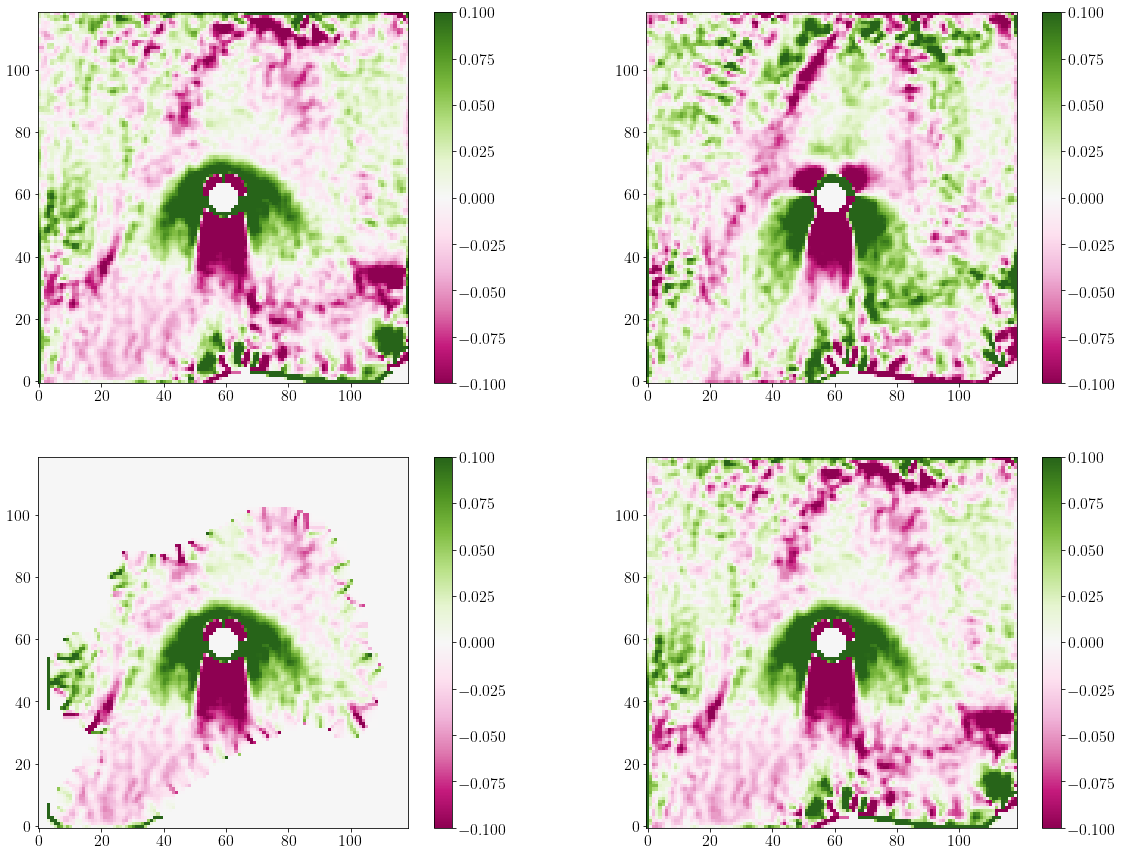

In [9]:
plt.rcParams['figure.figsize'] = [20, 15] # taille par défaut des figures qu'on trace

fig, axs = plt.subplots(2,2)
axs = axs.ravel()
plan=10
v=0.1
f1=axs[0].imshow(div_2D[plan],vmin=-v,vmax=v,cmap=colormap2)
axs[0].invert_yaxis()
fig.colorbar(f1, ax=axs[0])
f2=axs[1].imshow(div_2Db[plan],vmin=-v,vmax=v,cmap=colormap2)
axs[1].invert_yaxis()
fig.colorbar(f2, ax=axs[1])
f3=axs[2].imshow(div_2Dc[plan],vmin=-v,vmax=v,cmap=colormap2)
axs[2].invert_yaxis()
fig.colorbar(f3, ax=axs[2])
f4=axs[3].imshow(div_2Dd[plan],vmin=-v,vmax=v,cmap=colormap2)
axs[3].invert_yaxis()
fig.colorbar(f4, ax=axs[3])



# Application dans les 4 cas de Galerkine

In [10]:
m=15
vz,dvz,div2d,div3d=methode_Galerkine_2(umo,vmo,x,y,z,P,m,prof)

vzb,dvzb,div2db,div3db=methode_Galerkine_2(ume,vme,x,y,z,P,m,prof)


u=np.copy(umo)
v=np.copy(vmo)
u[cu<=50]=np.nan
v[cv<=50]=np.nan
vzc,dvzc,div2dc,div3dc=methode_Galerkine_2(u,v,x,y,z,P,m,prof)
u0=np.copy(u)
v0=np.copy(v)
x0=np.copy(x)
y0=np.copy(y)
u=np.copy(umo)
v=np.copy(vmo)
velocity=np.sqrt(u**2+v**2)
u[velocity<np.sqrt(uva+vva)]=np.nan
v[velocity<np.sqrt(uva+vva)]=np.nan
vzd,dvzd,div2dd,div3dd=methode_Galerkine_2(u,v,x,y,z,P,m,prof)



C:\Users\clement.gouiller\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less
C:\Users\clement.gouiller\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less


## Affichage de div 3D pour un plan (x,y) dans les 4 cas

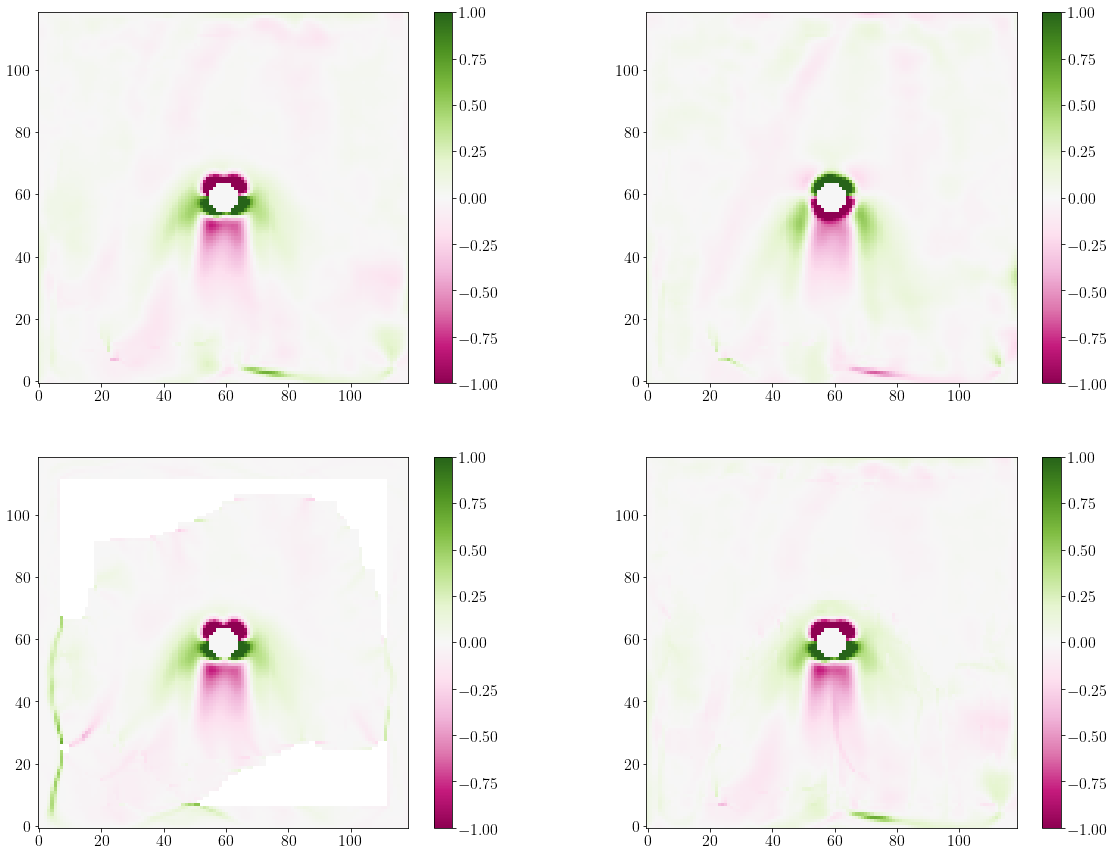

In [18]:
plt.rcParams['figure.figsize'] = [20, 15] # taille par défaut des figures qu'on trace

fig, axs = plt.subplots(2,2)
axs = axs.ravel()
plan=10
v=1
f1=axs[0].imshow(div3d[plan],vmin=-v,vmax=v,cmap=colormap2)
axs[0].invert_yaxis()
fig.colorbar(f1, ax=axs[0])
f2=axs[1].imshow(div3db[plan],vmin=-v,vmax=v,cmap=colormap2)
axs[1].invert_yaxis()
fig.colorbar(f2, ax=axs[1])
f3=axs[2].imshow(div3dc[plan],vmin=-v,vmax=v,cmap=colormap2)
axs[2].invert_yaxis()
fig.colorbar(f3, ax=axs[2])
f4=axs[3].imshow(div3dd[plan],vmin=-v,vmax=v,cmap=colormap2)
axs[3].invert_yaxis()
fig.colorbar(f4, ax=axs[3])


## Ecart relatif entre dvz et div2d pour évaluer la réussite

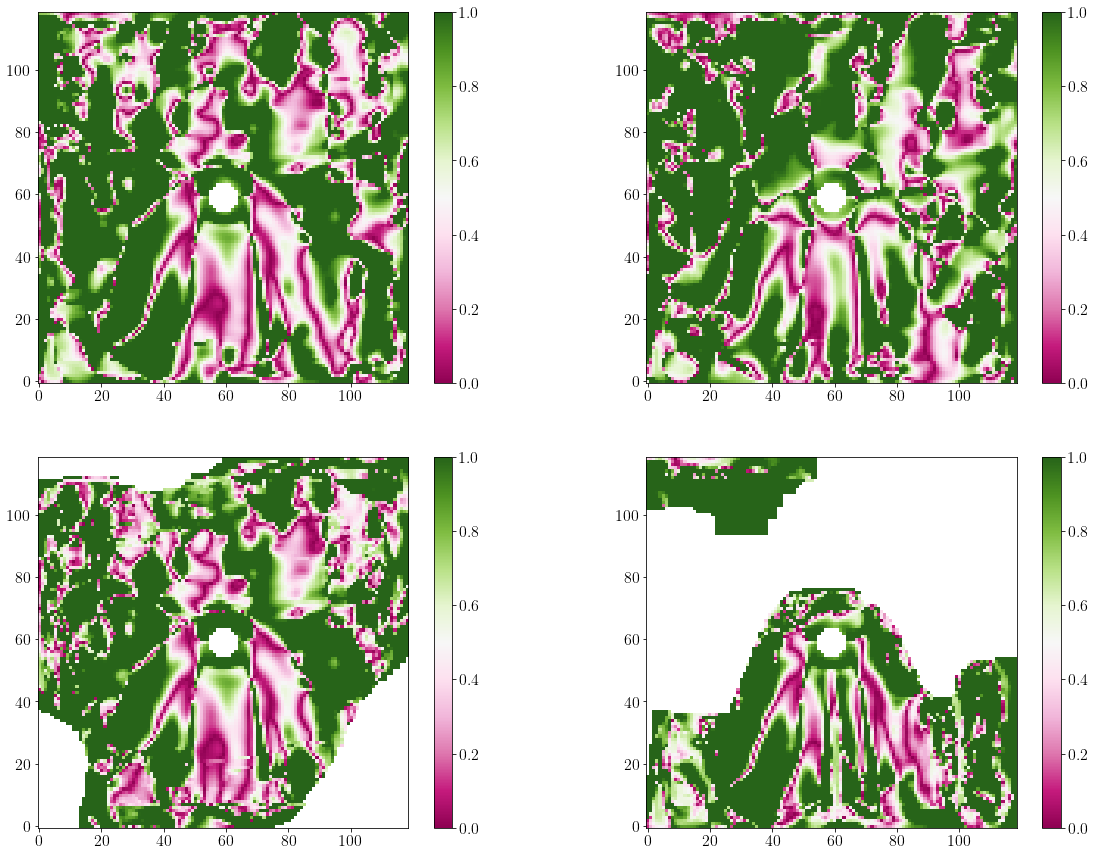

In [12]:
plan=15
d2d=np.copy(div2d)
d2d[d2d==0]=np.nan
d2db=np.copy(div2db)
d2db[d2db==0]=np.nan
d2dc=np.copy(div2dc)
d2dc[d2dc==0]=np.nan
d2dd=np.copy(div2dd)
d2dd[d2dd==0]=np.nan
fig, axs = plt.subplots(2,2)
axs = axs.ravel()
f1=axs[0].imshow(np.abs((dvz[plan]-d2d[plan])/d2d[plan]),vmin=0,vmax=1,cmap=colormap2)
axs[0].invert_yaxis()
fig.colorbar(f1, ax=axs[0])
f2=axs[1].imshow(np.abs((dvzb[plan]-d2db[plan])/d2db[plan]),vmin=0,vmax=1,cmap=colormap2)
axs[1].invert_yaxis()
fig.colorbar(f2, ax=axs[1])
f3=axs[2].imshow(np.abs((dvzc[plan]-d2dc[plan])/d2dc[plan]),vmin=0,vmax=1,cmap=colormap2)
axs[2].invert_yaxis()
fig.colorbar(f3, ax=axs[2])
f4=axs[3].imshow(np.abs((dvzd[plan]-d2dd[plan])/d2dd[plan]),vmin=0,vmax=1,cmap=colormap2)
axs[3].invert_yaxis()
fig.colorbar(f4, ax=axs[3])


# Comparaison entre dvz et div2D pour des points (i,j) et un nombre de modes m choisis

In [13]:
z=np.linspace(0,prof,P)
vz,dvz,div_2D,div_3D=methode_Galerkine_2(u0,v0,x0,y0,z,P,m,prof)



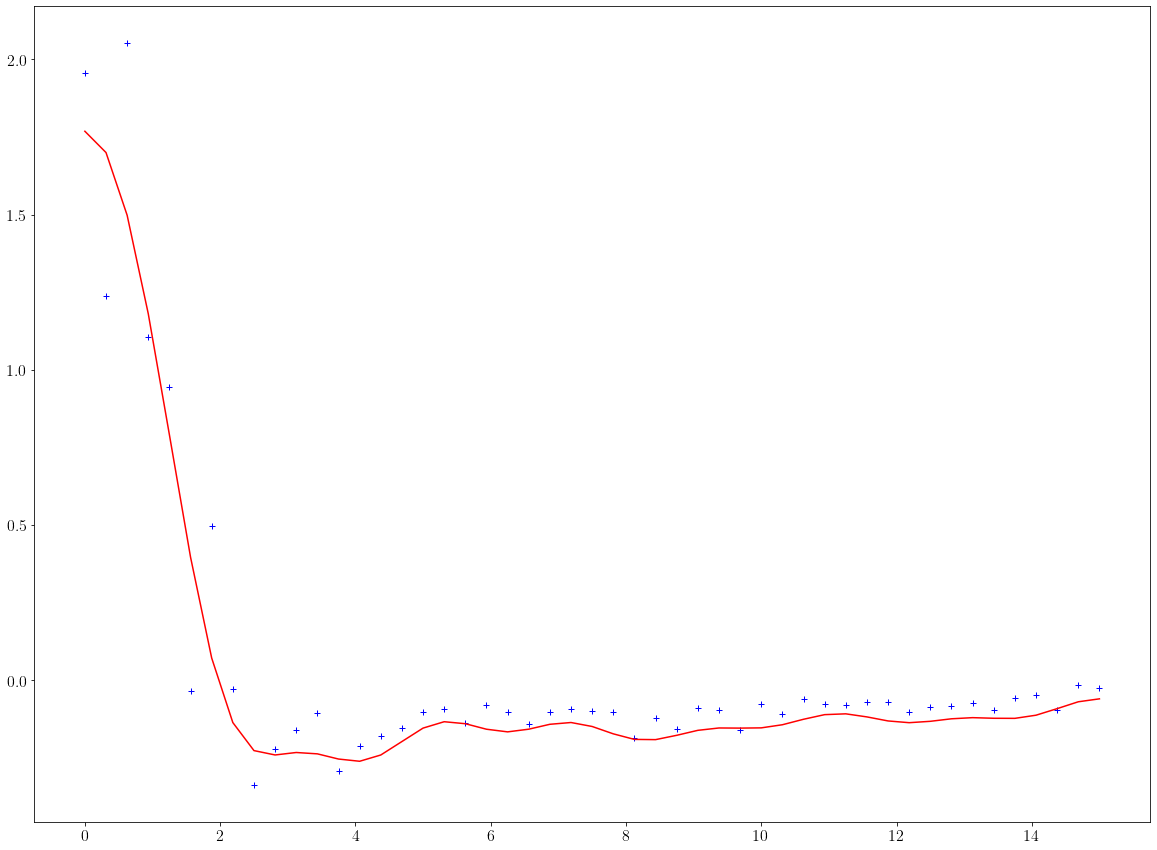

In [14]:
m=15
i=50
j=65
divij=div_2D[:,i,j]
zcor=z[divij==divij] #False pour un NaN, True sinon
divijcor=divij[divij==divij]
plt.plot(zcor,divijcor,'+b',z,dvz[:,i,j],'-r')

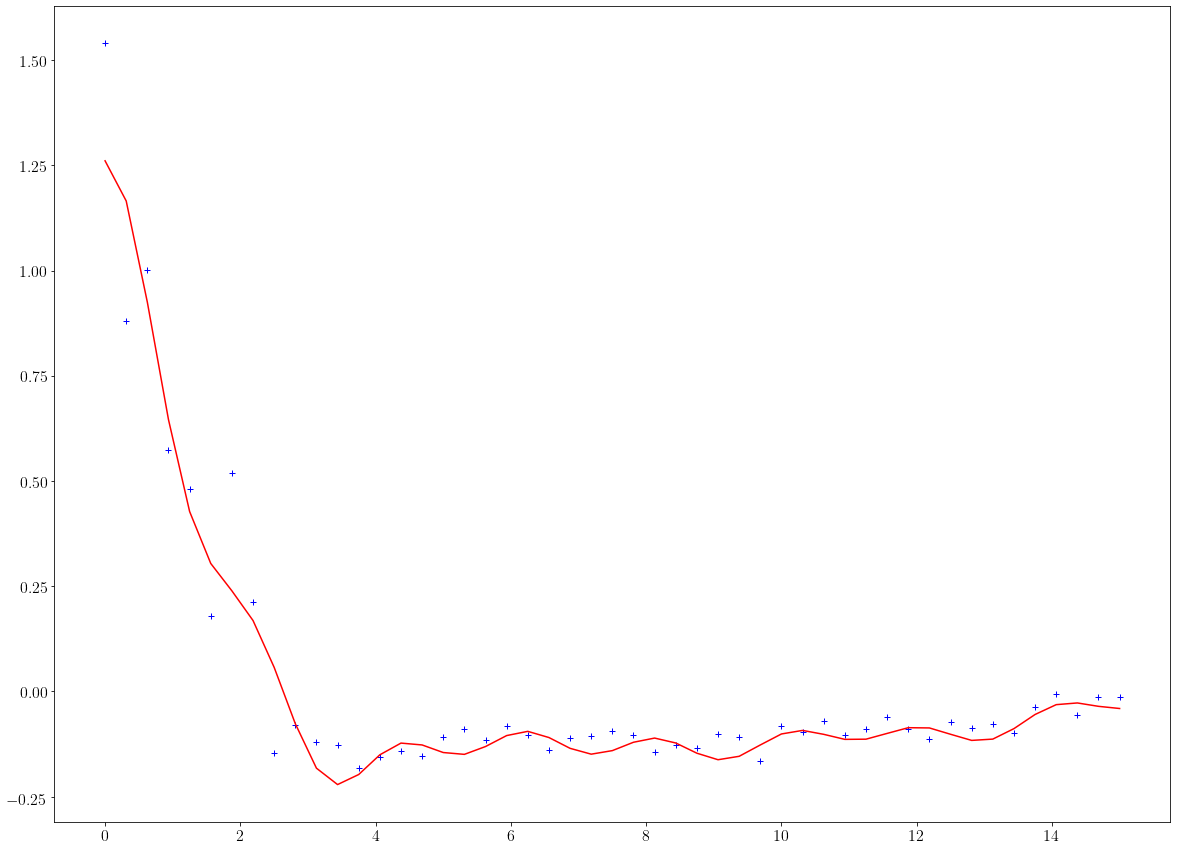

In [15]:
m=15
i=40
j=55
divij=div_2D[:,i,j]
zcor=z[divij==divij] #False pour un NaN, True sinon
divijcor=divij[divij==divij]
plt.plot(zcor,divijcor,'+b',z,dvz[:,i,j],'-r')

# Essais pour la thèse (ne pas en tenir compte)

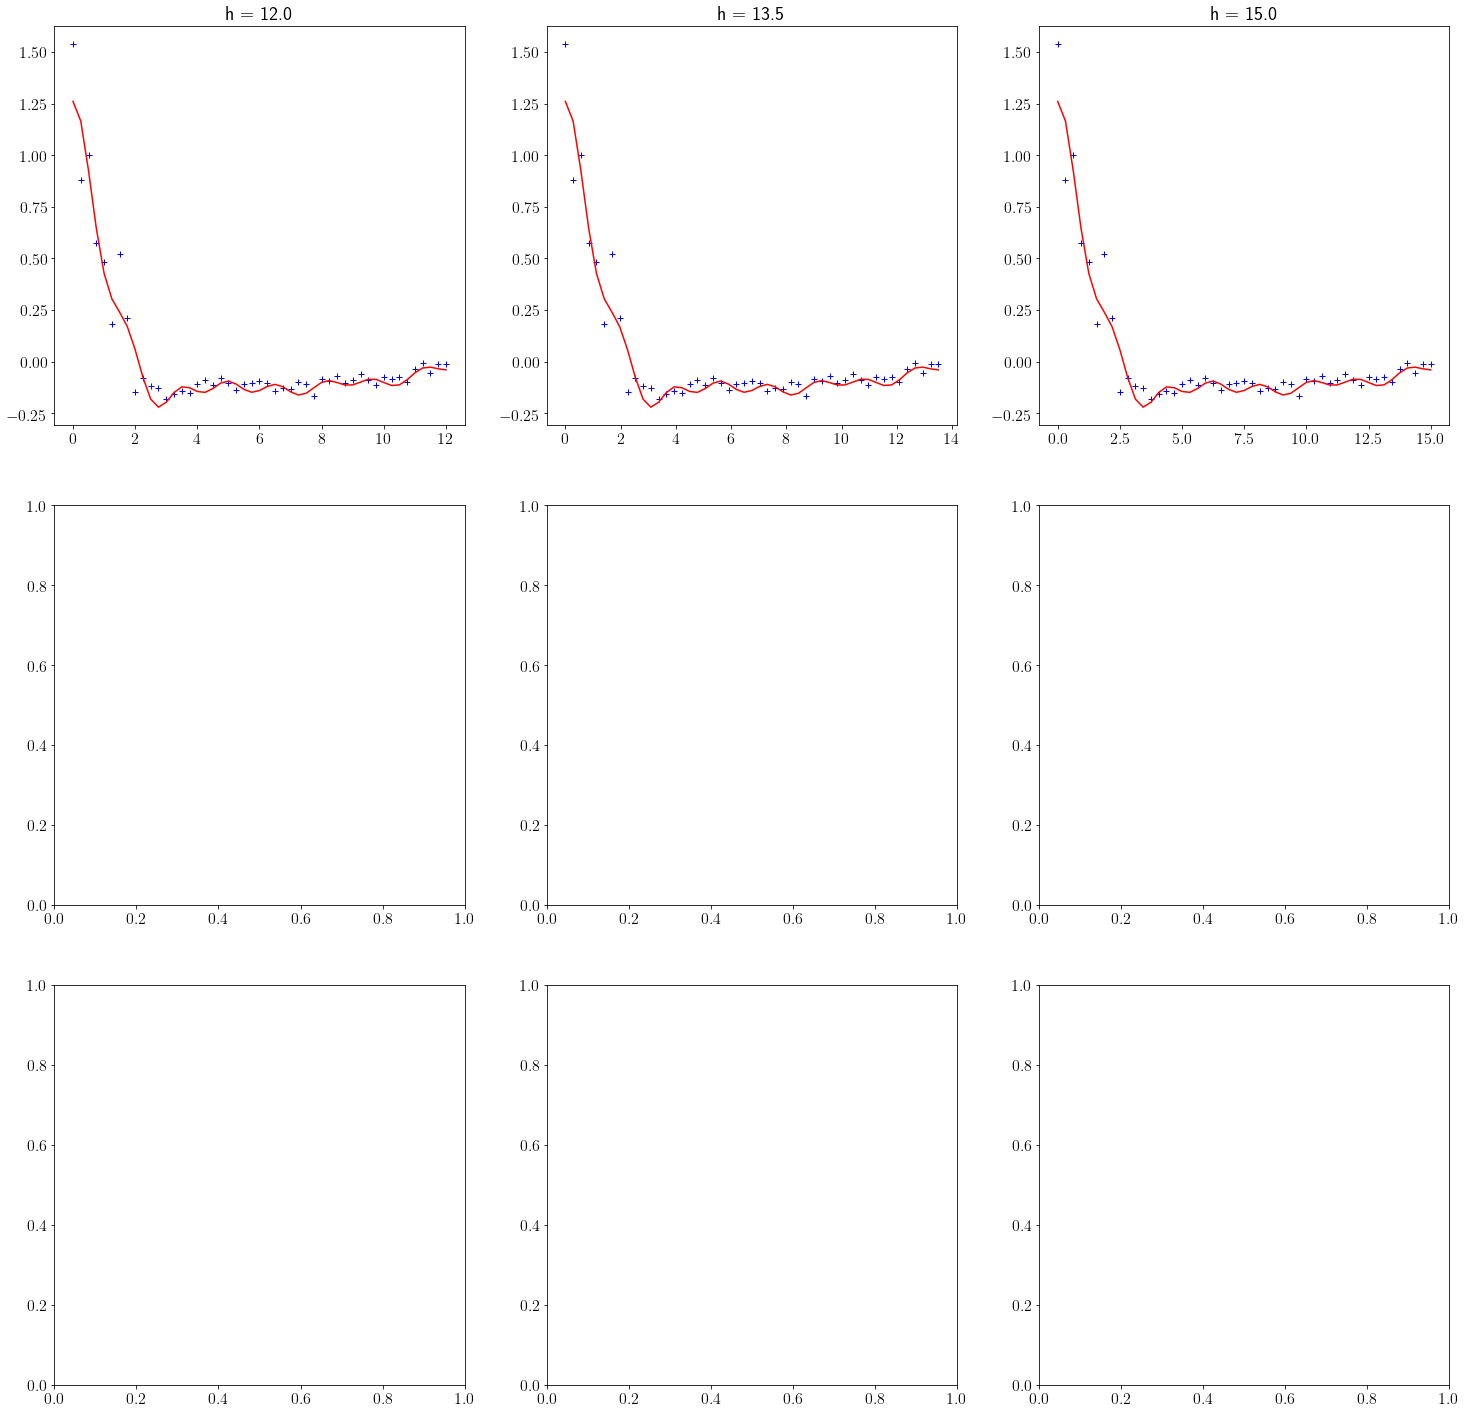

In [16]:
plt.rcParams['figure.figsize'] = [25, 25] # taille par défaut des figures qu'on trace

fig, axs = plt.subplots(3,3)
axs = axs.ravel()
cpt=0
for proft in np.linspace(prof-3,prof,3):
    z=np.linspace(0,proft,P)
    vz,dvz,div_2D,div_3D=methode_Galerkine_2(u0,v0,x0,y0,z,P,m,proft)
    divij=div_2D[:,i,j]
    zcor=z[divij==divij] #False pour un NaN, True sinon
    divijcor=divij[divij==divij]
    axs[cpt].plot(zcor,divijcor,'+b',z,dvz[:,i,j],'-r')
    axs[cpt].set_title('h = '+str(proft))

    cpt=cpt+1
plt.rcParams['figure.figsize'] = [8, 4.5] # taille par défaut des figures qu'on trace



ValueError: too many values to unpack (expected 2)

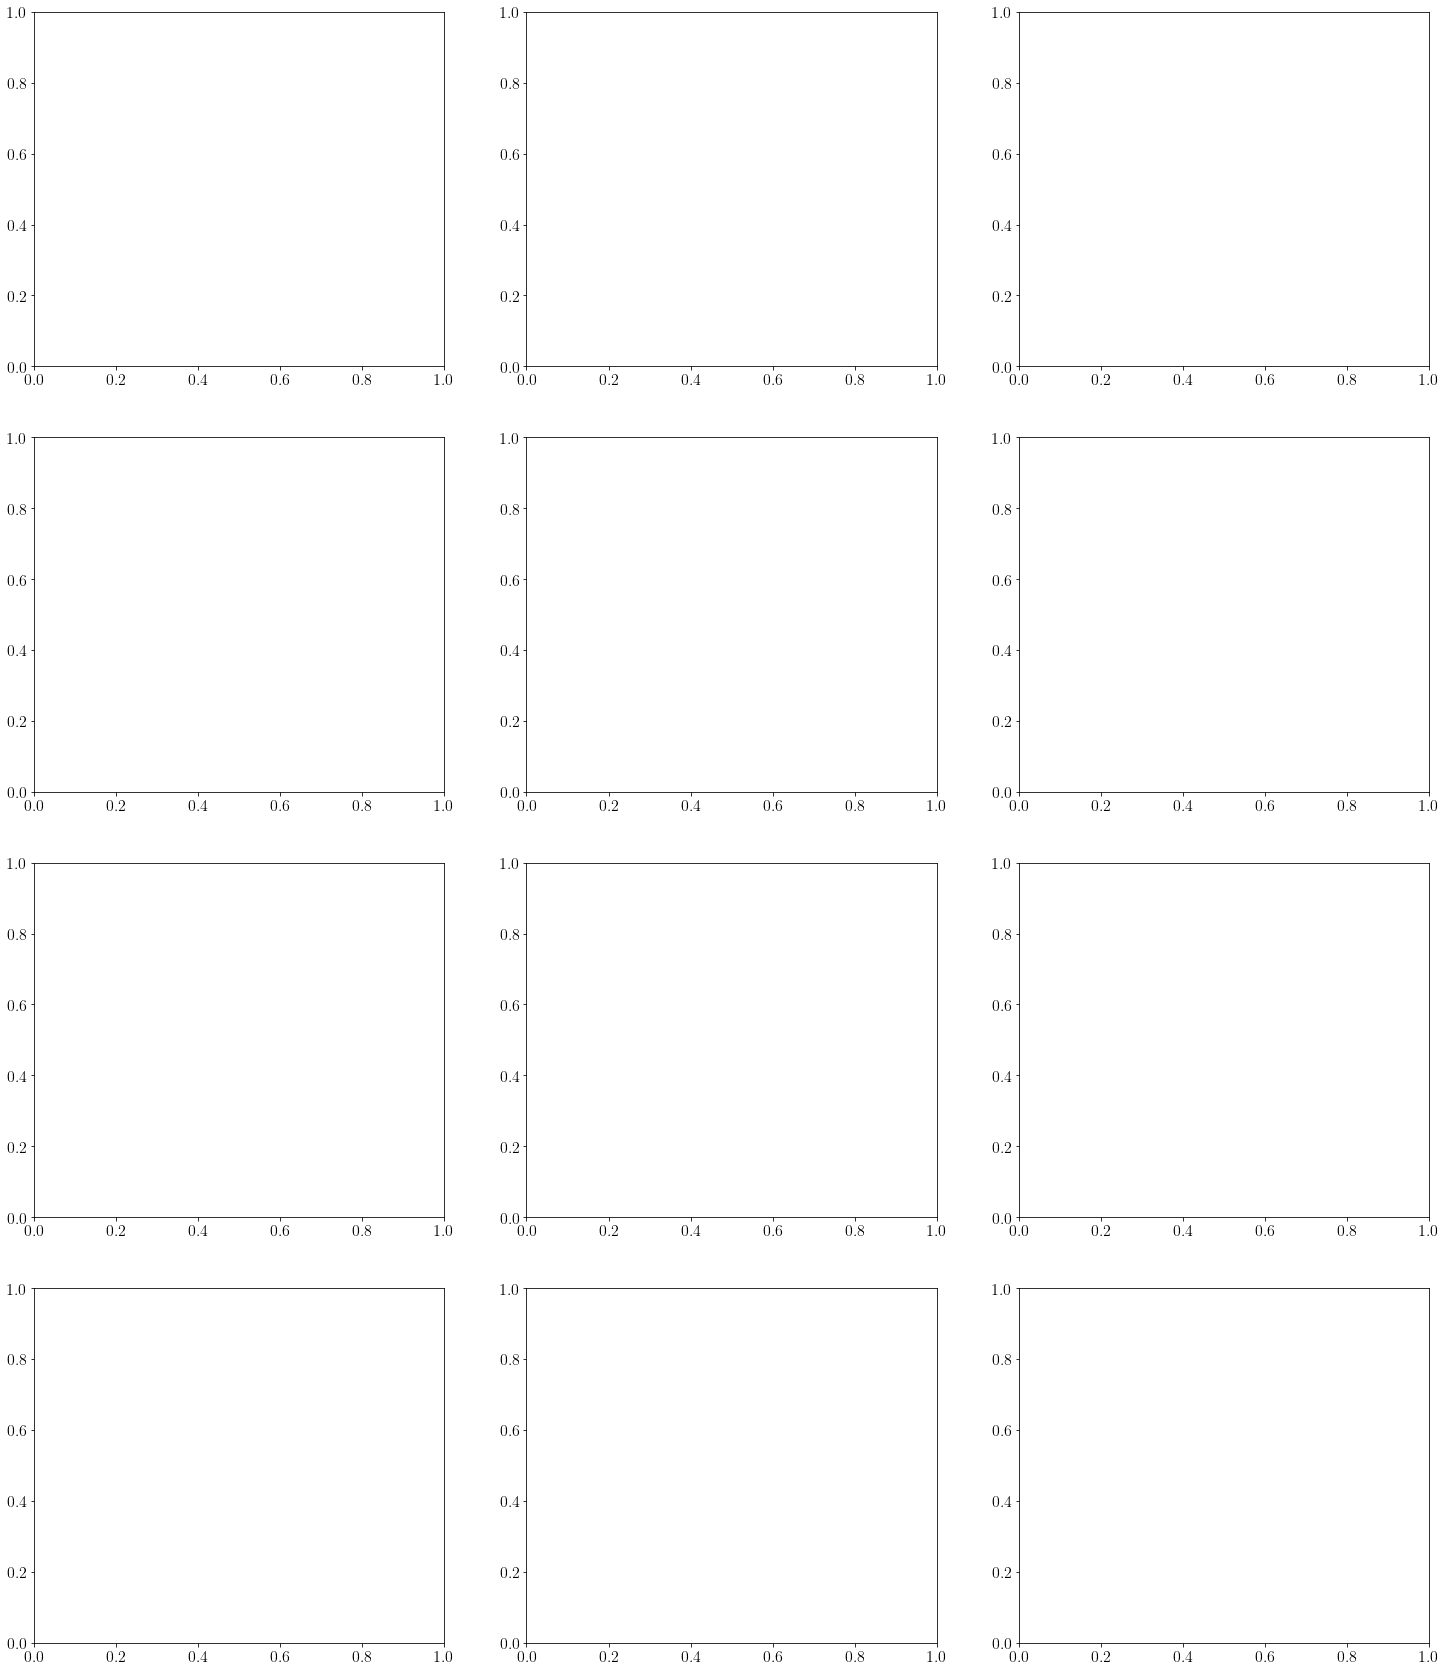

In [17]:
plt.rcParams['figure.figsize'] = [25, 30] # taille par défaut des figures qu'on trace

fig, axs = plt.subplots(4,3)
axs = axs.ravel()
cpt=0
for mt in np.arange(3,26,4):
    z=np.linspace(0,prof,P)
    vz,dvz=methode_Galerkine_2(u0,v0,x0,y0,z,P,mt,prof)
    divij=div_2D[:,i,j]
    zcor=z[divij==divij] #False pour un NaN, True sinon
    divijcor=divij[divij==divij]
    axs[cpt].plot(zcor,divijcor,'+b',z,dvz[:,i,j],'-r')
    axs[cpt].set_title('m = '+str(mt))

    cpt=cpt+1
plt.rcParams['figure.figsize'] = [8, 4.5] # taille par défaut des figures qu'on trace


In [ ]:
plt.rcParams['figure.figsize'] = [25, 20] # taille par défaut des figures qu'on trace

fig, axs = plt.subplots(2,3)
axs = axs.ravel()
cpt=0
for zt in np.linspace(0,0.3,3):
    z=zt+np.linspace(0,14.7,P)
    vz,dvz=methode_Galerkine_2(u0,v0,x0,y0,z,P,m,prof)
    divij=div_2D[:,i,j]
    zcor=z[divij==divij] #False pour un NaN, True sinon
    divijcor=divij[divij==divij]
    axs[cpt].plot(zcor,divijcor,'+b',z,dvz[:,i,j],'-r')
    axs[cpt].set_title('zt = '+str(zt))

    cpt=cpt+1
plt.rcParams['figure.figsize'] = [8, 4.5] # taille par défaut des figures qu'on trace
